<h1 align="center"> TP6 : Implementation of variational damage gradient models for brittle fracture </h1>
<h2 align="center"> Jeremy Bleyer, Corrado Maurini </h2>

> **Objectives**:
> * Implement variational damage gradient models for brittle fracture
> * Check the numerical behaviour of localized 1D solutions 
> * Study the influence of the regularization length scale and the mesh size on the solution

We consider the gradient damage models presented in class: 
\begin{equation}
\mathcal{E}(u,d) = \mathcal{E}_{el}(u,d) + \mathcal{E}_f(u,d) = \int_\Omega \psi(\boldsymbol{\varepsilon}(u), d) \,\text{d}\Omega + \int_\Omega \dfrac{G_c}{\ell_0 c_w}\left(w(d)+\ell_0^2\nabla d\cdot\nabla d\right)\,\text{d}\Omega
\end{equation}
with an elastic energy density of the form:
\begin{equation}
\psi(\boldsymbol{\varepsilon},d) = \left((1-d)^2+\kappa_{res}\right)\dfrac{1}{2}\boldsymbol{\varepsilon}:\mathbb{C}_0:\boldsymbol{\varepsilon}
\end{equation}
and the two modelsfor the fracture energy:
\begin{equation}
\textsf{AT1}\qquad w(d)=d \quad; \quad c_w = \dfrac{8}{3} \tag{AT1}
\end{equation}
or
\begin{equation}
\textsf{AT2}\qquad w(d)=d^2 \quad; \quad c_w = 2 \tag{AT2}
\end{equation}

## Implementation

All the simulations are done in plane stress conditions

1. In `damage_gradient.py`, define using UFL operators the following functions:
* `g(d)` computing the degradation function as a function of a damage field `d`. You can use the already-defined residual stiffness constant `kres`.
* `psi(u)` computing the non-damaged elastic strain energy density as a function of `u`. You can use the already-defined `eps(u)` function for the strain and `sigma0(u)` for the non-damaged stress.
* the forms `elastic_energy` and `fracture_energy` corresponding to $\mathcal{E}_\text{el}$ and $\mathcal{E}_\text{frac}$ as a function of the unknown displacement `u` and damage field `d`

2. Run the simulation to check the behaviour of the homogeneous solution for both AT1 and AT2 models.

> ```python 
> def g(d):
>     return (1 - d) ** 2 + kres
> 
> def psi(u):
>     return 0.5 * inner(eps(u), sigma0(u))
>
> elastic_energy = g(d) * psi(u) * dx
> fracture_energy = Gc / cw * (w(d) / l0 + l0 * dot(grad(d), grad(d))) * dx
> ```
> We verify that both models yield the expected homogeneous solutions (with a non-zero elastic phase for AT1).

## Localized 1D solutions

We consider the same problem with $\ell_0 = 0.1$ and now `refinement_level=4`.
A refinement of level `k` yields a mesh with an element size of roughly $2^{-k}L$.
1. Launch the computation for AT1 and `Umax=3e-3`. What happens ?
2. Rerun the computation by imposing now `damage_bcs=True`. This keyword enforces the damage field to be zero at both extremities where displacement is fixed. What happens ?
3. What is the value of the dissipated energy ? What value do you expect theoretically for a localized solution ? Report the value of the dissipated energy for `refinement_level=5,6,7` and comment.
4. Do the same with $\ell_0 = 0.02$ and `Umax=5e-3`. Compare with the previous case.
5. Now, what happens for the AT2 model ?

> 1. We observe that the obtained solution corresponds to the homogeneous solution up to a certain strain level. Past this point, the solution localizes itself near one of the two boundaries and we obtain a smaller dissipated energy than the homogeneous case.
> 2. Boundary conditions now prevent the homogeneous damage solution to be admissible as soon $d>0$. We now obtain a localized solution where damage concentrates in the middle of the bar. Contrarily to the homogeneous solution for which we have $\sigma=0$ for $\varepsilon \to \infty$, here the stress instantaneously becomes zero (perfectly brittle behaviour).
> 3. We now have a dissipated energy of $0.1236G_c$, in theory we should have $G_c W = 0.1 G_c$ for a vertical crack splitting the bar in two. Upon mesh refinement, we obtain:
\begin{equation*}
\begin{array}{|c|c|c|c|c|c|}
\hline
\ell_0 & \texttt{level} & 4 & 5 & 6 & 7\\
\hline
0.1 & \text{Dissipated energy}/(G_cW) & 1.235 & 1.107 & 1.060 & 1.033 \\
\hline
0.02 & \text{Dissipated energy}/(G_cW) & 2.242 & 1.562 & 1.297 & 1.154\\
\hline
\end{array}
\end{equation*}
> For a fixed value of $\ell_0$, we thus observe that the dissipated energy tends to converge to the expected theoretical value. The mesh size needs to be sufficiently small with respect to $\ell_0$ in order to obtain a good estimate of the dissipated energy. 
> 4. We still obtain the same behaviour, that is a localized solution in the middle. The main difference is the size of the localization band which is equal to $4\ell_0$. Moreover, changing the value of $\ell_0$ changes the critical strain $\varepsilon_c$ for which localization occurs. Finally, we also observe that, for a fixed mesh size, reducing $\ell_0$ increases the error on the dissipated energy. Indeed, we can show that the numerical dissipated energy is in fact of the form:
\begin{equation}
\mathcal{E}_{f,num} = G_c H\left(1+C\dfrac{h}{\ell_0}\right)
\end{equation}
> where $h$ is the characteristic mesh size and $C$ a positive constant which does not depend on $h$ or $\ell_0$. The numerical dissipation therefore overestimates the true dissipation.
> 5. Globally, we observe a similar behaviour. The main difference with respect to AT1 is related to the absence of an elastic phase. However, we obtain initially a solution which is almost homogeneous (except close to the boundary conditions). Then the solution localizes in the middle and the stress drops to zero. The size of the localization band is again related to $\ell_0$. The initially diffuse damage field prevents us from obtaining the exact dissipated localized solution. This lack of an elastic phase make the AT1 model slightly more interesting for real applications than the AT2 model.

## Notched tension
We now consider `refinement_level=0`, `Umax=2.5e-3` and `damage_bcs=False`. We also change the problem type to `problem="notched"` corresponding to a similar plate in tension (same boundary conditions), of dimensions $L × H = 1 × 0.5$, perforated by two notches of radius $R=$`notch_radius`, horizontal spacing (`notch_spacing`) and aspect ratio (`aspect_ratio`).

1. We take $R = 0.2$ and $\ell_0 = 0.1$. Run the computation for AT2 and comment. What happens upon mesh refinement?
2. What can we say for $\ell_0 = 0.05, 0.025$ ?
3. Now change to $R = 0.2$ and `aspect_ratio=100`. What is the influence of $\ell_0$ in this case compared to the previous case ?

> 1. We get a brittle elastic behaviour with damage concentrating in the the central part of the plate. The lack of an elastic phase in the AT2 model is not very pronounced here because it only concerns the zones where damage starts evolving, i.e. the zones of stress concentration. Damage remains almost zero far from these zones where the localization band appears. The solution fully localizes to a crack before the remaining zones can experience a significant damage level. Contrary to the homogeneous bar in traction, we get here a localized solution which is close to the theoretical 1D solution in $\exp(-|x-x_0|/\ell_0)$. Upon mesh refinement, the dissipated energy slightly decreases but the solution remains very similar, we thus have convergence.
> 2. If $\ell_0$ decreases the critical stress corresponding to the localization increases, the dissipated energy is however very similar if mesh refinement is enough to resolve the typical length $\ell_0$, the excess of elastic energy being lost should however be transformed into kinetic energy in a dynamics setting.
> 3. We still see the same type of result as before. However, when $\ell_0$ decreases, we observe that the critical strain/stress is much less dependent on $\ell_0$. Here is an explanation for this observation: for $\ell_0$ being sufficiently small compared to the structure typical size, if we are in presence of stress concentrations only (holes, curved boundaries), the critical stress (corresponding to the end of the localization phase for instance) will depend on $\ell_0$ because the failure is driven by a stress criterion. If, on the opposite, the structure exhibits stress singularities (such as pre-cracks) so that failure is driven by a purely Griffith-like energetic criterion, then the solution will no longer depend on the value of the regularization length $\ell_0$ (in case of a sufficiently refined mesh). This aspect is discussed in details in the following paper:
> Tanné, E., Li, T., Bourdin, B., Marigo, J. J., Maurini, C. (2018). Crack nucleation in variational phase-field models of brittle fracture. *Journal of the Mechanics and Physics of Solids*, 110, 80-99.

## Cracking in mode II
We now consider `problem="shear"` with $L=H=1$.
This problem corresponds to a shear loading of a cut-out block by applying an horizontal
displacement on the top face, the bottom face being fixed. The pre-crack is therefore loaded
initially in mode II.

1. First change the boundary conditions accordingly: `facets=2` is the bottom boundary, `facets=4` is the top boundary. Run the computation for the AT1 model with $\ell_0 = 0.04$, `Nincr = 50` and `Umax=6e-3`. What can we observe regarding the crack path ? 
2. By considering how the top block
moves, what can you say about the top crack ? What should happen in reality ?
3. Amor et al. proposed the following tension/compression splitting model:
\begin{align}
\psi(\boldsymbol{\varepsilon},d) &= g(d)\psi_+(\boldsymbol{\varepsilon}) + \psi_-(\boldsymbol{\varepsilon})\\
\psi_+(\boldsymbol{\varepsilon}) &= \dfrac{1}{2}\kappa\langle\textrm{tr}(\boldsymbol{\varepsilon})\rangle_+^2 + \mu\textrm{dev}(\boldsymbol{\varepsilon}):\textrm{dev}(\boldsymbol{\varepsilon})\\
\psi_-(\boldsymbol{\varepsilon}) &= \dfrac{1}{2}\kappa\langle\textrm{tr}(\boldsymbol{\varepsilon})\rangle_-^2 
\end{align}
Adapt the value of the elastic energy using the functions `psi_pos` and `psi_neg` and run again the simulation with this model.

4. What happens when using the AT2 model ? What can we expect upon mesh refinement and smaller regularization length ?

> 1. We observe that the cracks splits into two symmetric branches. First, propagation of a crack in mode II (horizontally) for a homogeneous isotropic material is generally not possible. The crack tends to orient itself so that it propagates in mode I. Let us note that the choice of a proper criterion ($K_{II}=0$, $G$max, etc.) for the orientation angle remains an open question since the Griffith model is unable to answer this question. Gradient damage models will naturally predict a crack branching as a result of an energy minimization process. Note also that with a sufficiently refined mesh and a smaller $\ell_0$, the first small horizontal propagation phase disappears and the crack branches from the pre-crack tip.
> 2. Nevertheless, accounting for how the top block moves, we see that the bottom crack opens whereas the top crack closes itself. Mode I propagation for the top crack should not happen because $K_I<0$. Thus, there should be a single bottom crack only. This behaviour is due to the fact that, with the present formulation, the whole elastic energy density is damaged, even when the material is in a compression state. The behaviour in tension has not been distinguished from the behaviour in compression. It is therefore possible to crack in a compressive mode I which is not realistic, because we are not considering unilateral contact conditions on the crack lips.
> 3. Due to the absence of any elastic phase, the AT2 model exhibits a diffuse damage field of low intensity. The model is therefore much more influenced by boundary effects due to this initial field than the AT1 model. This influences the orientation of the kinked crack. It is more difficult to observe a well kinked crack with AT2 than AT1. However, we should expect that, upon mesh refinement and smaller regularization length, both solutions will approach that of the Griffith model. We indeed observe a better kinked crack for AT2 using `refinement_level=1` and $\ell_0=0.02$.

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00043514s, CPU 0.000719s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000460817s, CPU 0.000852s)
Info    : 8 nodes 18 elements


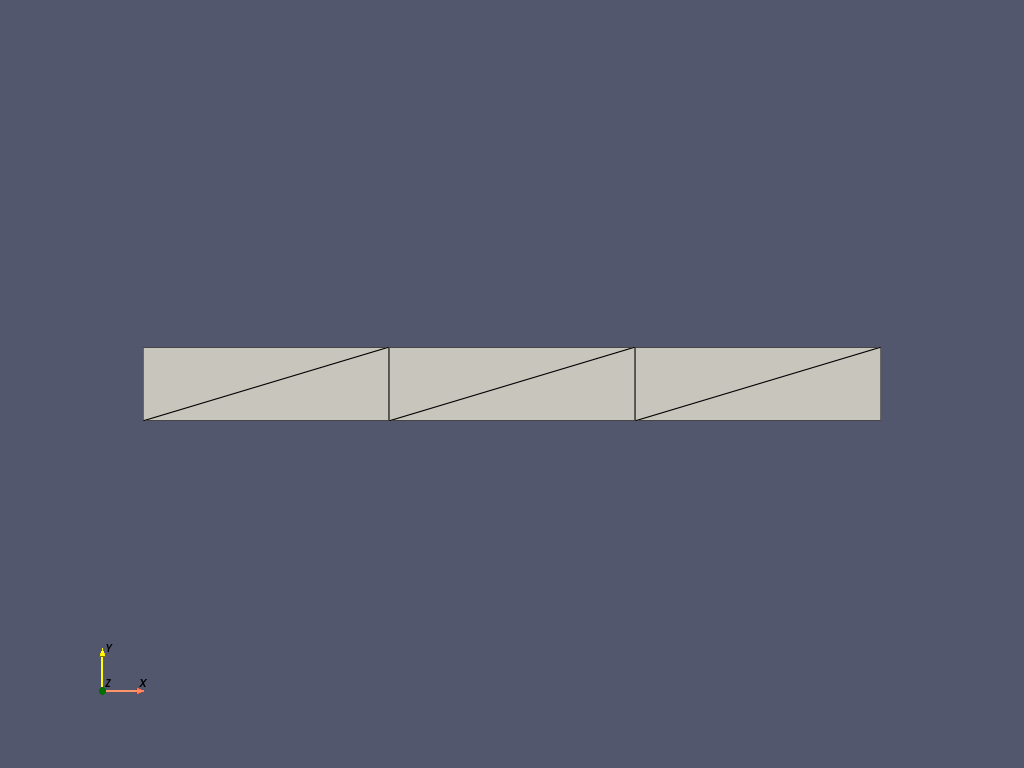

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from damage_gradient import solve_problem
from mealor.utils import plot_over_line
from mealor.plotting import plot_mesh
from generate_mesh import setup_geometry

L = 1.0
H = 0.1
problem_type = "bar"
domain, facets = setup_geometry(problem_type, L, H, refinement_level=0)
plot_mesh(domain)

In [2]:
# Material parameters
E = 3.0e3
nu = 0.3
Gc = 3e-3
l0 = 0.1
model = "AT1"
Nincr = 50
Umax = 5e-3
mech_params = (E, nu, Gc, l0, model, Umax, Nincr)

# boundary conditions
damage_bcs = False
def generate_bcs(dirichlet, Uimp):
    # ux = Uimp on right boundary
    dirichlet.add_bc_topological(facets, 3, ux=Uimp)
    # ux = 0 on left boundary
    dirichlet.add_bc_topological(facets, 1, ux=0)    
    # uy = 0 on x=y=0 point
    dirichlet.add_bc_geometrical(
        lambda x: np.logical_and(np.isclose(x[0], 0), np.isclose(x[1], 0)), uy=0
        )
    
# Alternate minimization parameters
Niter_max = 100 
tol = 1e-6

prob_params = (problem_type, generate_bcs, damage_bcs, Niter_max, tol)
results, u, d, sig = solve_problem(
    domain, facets, prob_params, mech_params
)

Increment   1
    Iteration   0: ||Res||_2=0.000000e+00


NameError: name 'sigma' is not defined

In [7]:
Uimp = results[:, 0]
Force = results[:, 1]
elastic = results[:, 2]
fracture = results[:, 3]

S0 = 0.1
print("Final dissipated energy [/Gc)]", fracture[-1]/Gc)
print(f"Maximum stress {max(Force/S0)}")

Final dissipated energy [/Gc)] 0.11863744195313683
Maximum stress 8.569914680342148


### Plot stress curve and energies

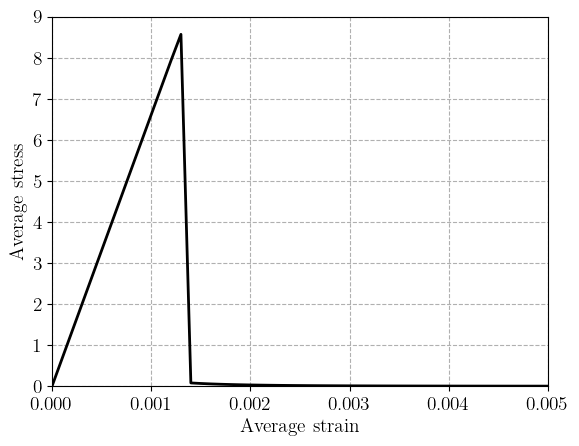

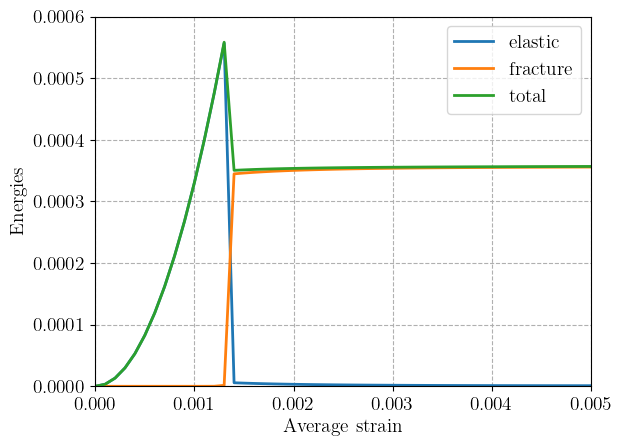

In [8]:
plt.plot(Uimp/L, Force/S0, '-k')
plt.xlabel("Average strain")
plt.ylabel("Average stress")
plt.show()

plt.figure()
plt.plot(Uimp/L, elastic, label="elastic")
plt.plot(Uimp/L, fracture, label="fracture")
plt.plot(Uimp/L, elastic + fracture, label="total")
plt.xlabel("Average strain")
plt.ylabel("Energies")
plt.legend()
plt.show()

### Plot localized solution profiles

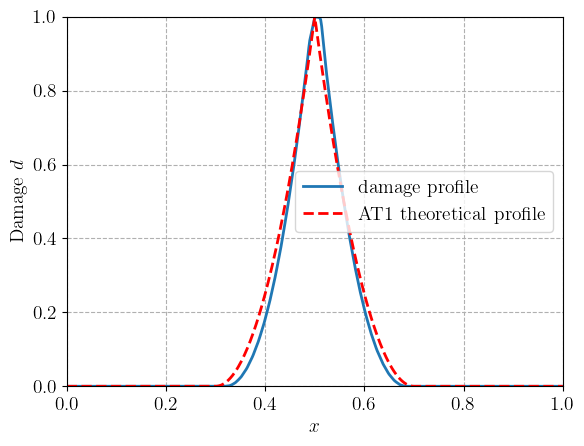

In [5]:
line = [(0., H / 2), (1.0, H / 2)]
dv, points = plot_over_line(d, line, domain)
x = points[:, 0]

pos = lambda x: (x+np.abs(x))/2.0

profile = {"AT2": np.exp(-np.abs(x - L / 2) / l0),
            "AT1": (pos(1-np.abs(x-L/2)/2/l0))**2}

plt.plot(x, dv, "-", label="damage profile")
plt.xlabel(r"$x$")
plt.ylabel(r"Damage $d$")
plt.ylim(0, 1)
plt.plot(x, profile[model], "--r", label=f"{model} theoretical profile")
plt.legend()
plt.show()